### Time Resolved Photoluminescence Modeling

In a TRPL experiment the sample is hitted by a laser pulse of a very short time (picoseconds) which generates a first excess carrier density *n(0)*. This value decays in time due to charge recombination processes happening in the material.
The overall decay of the excess carrier density results in a exponential decay curve that is normally fitted with a multiple exponential. But the main limitation is that lifetime constants are extrapoleted by these fitting curve which do not explain precisely the physical processes which play simultaneously a role in the decay dynamics. 

For these reasons, we want to analyze in details the processes of generation and recombination of charges that happen after excitation to find the best and most precise way to get information on carrier recombination processes.

We start from the continuity equation which describe the number of photogenerated excess carrier in time:

$\frac{\delta(n)}{\delta(t)} = - R_1(z,t) - R_2(z,t)$

* $R_1$ is the recombination constant associated with Shockley Read Hall (SRH) recombination

$R_1 = \frac{(n_0 + n)(p_0 + p) - n_i^2}{(n_0 + n) + (p_0 + p) + 2n_icosh\frac{(E_i - E_t)}{kT}} \sigma \nu_{th} N_t$

* $R_2$ is the recombination rate associated with the band-to-band recombination (bimolecular process)


LLI
$R_2(z, t) = k_2[p(p_0)]$

HLI
$R_2(z, t) = k_2[p^2]$

The Auger recombination is negligible under the normal working condition of solar cells (below an excess carrier density of $10^{17} cm^{−3}$ )

* **Low Level Injection regime: $n=p<<p_0$**

Under low injection level (LLI) conditions, the photocarrier
density *n* is much lower than the equilibrium density of the
majority carriers; $R_1$ can be expressed as a linear function of the
photocarrier density *n(z,t)*. 
Approximation:

$R_1 = k_1n(z,t)$

Where $k_1$ is the SRH recombination frequency(?=constant?)

Approximation of $R_2$:

$R_2 = k_2p_0p$

**Continuity equation at LLI**

$\frac{\delta(n)}{\delta(t)} = -(k_1 + k_2p_0)p$

$k_2p_0$ is non-negligible only if the
absorbing layer is highly doped 
($k1 = 10^7 s^{−1}$ and $k_2 = 10^{−10} \frac{cm^3}{s}, p_0 > 10^{17} cm^{−3}$). 
Therefore, under LLI conditions and low doping concentration, the decay of the photogenerated carriers is mainly controlled by the SRH recombination rate $k_1$

**Continuity equation at HLI**

$\frac{\delta(n)}{\delta(t)} = -(k'_1 + k_2p_0)p - k_2p^2$  

where $k'_1$ 

Approximation of the existance of only deep level traps:

**LLI** : $\frac{\delta(n)}{\delta(t)} = -(k_1 + k_2p_0)p - k_2p^2$ 

**HLI** : $\frac{\delta(n)}{\delta(t)} = -(\frac{k_1}{2} + k_2p_0)p - k_2p^2$ 

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from scipy.stats import exponnorm
#from customplotting.general import plot_xy, save_fig
from functions import *
from scipy.stats import norm
import pandas as pd

In [2]:
"""Recycle params for plotting"""
plt.rc('xtick', labelsize = 30)
plt.rc('xtick.major', pad = 3)
plt.rc('ytick', labelsize = 30)
plt.rc('lines', lw = 3.5, markersize = 20.5)
plt.rc('legend', fontsize = 30)
plt.rc('axes', linewidth = 3.5)

In [3]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [6]:
def herz_ode(t, n0, params):
    a = params[0]
    k1 = params[1]
    k2 = params[2]
    def odefun(n, t, k1, k2):    
        dndt = -(k1 * n) - (k2 * (n ** 2.0))
        return dndt
    ode_sol = odeint(odefun, n0, t, args = (k1, k2))[:,0]
    pl = k1 * (ode_sol) + k2 * (ode_sol ** 2.0)
    return a*pl

In [348]:
# overall decay
def decay(t, k1):
    def model(n, t):
        k2=1e-11
        p0=1e13
        dndt = -(k2*(n*p0*n) - k1*n)
        return dndt
    n0 = 1e12
    n = odeint(model, n0, t)
    return n

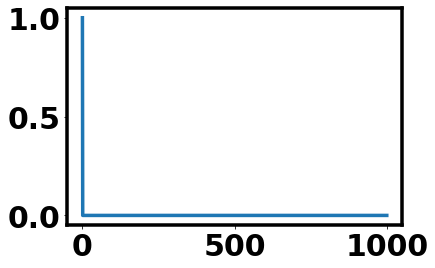

In [350]:
t = np.linspace(0,1000, 1000)
n = decay(t, 1e6)
plt.plot(t, n/np.max(n))

In [193]:
def decay_fit(TRPL, t, K1 = (1e15,1e16), K2 = (1e-10,1e-11)):
    def decay(t, k1, k2):
        def model(n, t):
            dndt = -(k2*(n**2) + k1*n)
            return dndt
        n0 = 1e18
        n = odeint(model, n0, t)
        pl = k1*n + k2 * (n**2)
        return pl

    def Diff_Ev_Fit(TRPL):

        def residuals(params):#params are the parameters to be adjusted by differential evolution or leastsq, interp is the data to compare to the model.
            #Variable Rates
            k1 = params[0]
            k2 = params[1]
            
            PL_sim = decay(t,k1,k2)

            Resid= (np.sum(((PL_sim-TRPL)**2)/(np.sqrt(PL_sim)**2)))
            return Resid #returns the difference between the PL data and simulated data

        bounds = [K1, K2]

        result = differential_evolution(residuals, bounds)
        return result.x

    p = Diff_Ev_Fit(TRPL)

    k1 = p[0]
    k2 = p[1]
    
    PL_fit = decay(t, k1, k2)


    return k1, k2, PL_fit

## High level injection regime equation

In [359]:
# HLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def photoluminescence_HLI(t, k1):
    def model(n, t):
        k2 = 1e-12
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = np.tile(np.power(10, 18), 50)
    n = odeint(model, n0, t)
    k2 = 1e-12
    pl_HLI = k2 * (n**2)
    return pl_HLI

In [360]:
# HLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def fit_HLI(t, k1):
    def model(n, t):
        k2 = 1e-12
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = 1.4e17
    n = odeint(model, n0, t)
    k2 = 1e-12
    pl_HLI = k2 * (n**2)
    return pl_HLI

## Low level injection regime equation

In [361]:
# LLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def photoluminescence_LLI(t, k1):
    def model(n, t):
        k2 = 6e-11
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = np.tile(np.power(10, 14), 50)
    n = odeint(model, n0, t)
    k2 = 6e-11
    p0 = 1e16
    pl_LLI = k2 * n* p0
    return pl_LLI

## 1) Simulation of PL decays in HLI with a *linear distribution* of K_nonrad from 10^5 to 10^7 cm-3 

In [363]:
# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_HLI = photoluminescence_HLI(t = np.linspace(0,5000, 5000)*1e-9, k1= np.logspace(5, 6, 50))
pl_HLI

array([[2.21003493e+06, 2.21003493e+06, 2.21003493e+06, ...,
        2.21003493e+06, 2.21003493e+06, 2.21003493e+06],
       [2.20959288e+06, 2.20957162e+06, 2.20954933e+06, ...,
        2.20601421e+06, 2.20582094e+06, 2.20561840e+06],
       [2.20915092e+06, 2.20910840e+06, 2.20906383e+06, ...,
        2.20200080e+06, 2.20161499e+06, 2.20121069e+06],
       ...,
       [8.13351766e+05, 7.75160270e+05, 7.37054601e+05, ...,
        2.46948306e+02, 1.59394342e+02, 1.00737658e+02],
       [8.13189080e+05, 7.74997763e+05, 7.36892650e+05, ...,
        2.46499032e+02, 1.59090416e+02, 1.00536344e+02],
       [8.13026426e+05, 7.74835291e+05, 7.36730734e+05, ...,
        2.46050575e+02, 1.58787070e+02, 1.00335432e+02]])

In [364]:
pl_HLI.shape

(5000, 50)

In [365]:
#x values of time
t = np.linspace(0,5000, 5000)*1e-9
t

array([0.00000000e+00, 1.00020004e-09, 2.00040008e-09, ...,
       4.99799960e-06, 4.99899980e-06, 5.00000000e-06])

In [366]:
#weighted sum of photoluminescence data
pl_HLI_sum = pl_HLI.sum(axis=0)
pl_HLI_sum.size

50

In [367]:
#weighted average og the photoluminescence data
pl_HLI_avg = np.average(pl_HLI, weights=pl_HLI_sum, axis=-1)
pl_HLI_avg.size

5000

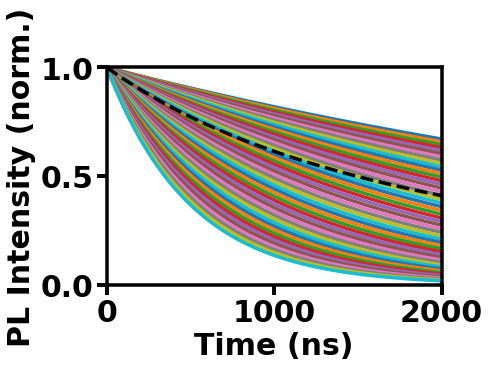

In [368]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_HLI/np.max(pl_HLI))
plt.plot(t*1e9, pl_HLI_avg/np.max(pl_HLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize=30, fontweight='bold')
plt.ylabel('PL Intensity (norm.)', fontsize= 30, fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0, 2000)
plt.ylim(0,1)
plt.show()

In [28]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 236.37155873497676
Beta = 0.79769627992869
avg. tau (ns) = 268.36478179011414


In [184]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 418.03886963277137
a1 = 0.47077769673259434
tau2 (ns) = 144.0382713631453
a2 = 0.46271247276226035
avg. tau (ns) = 282.2222338429327


In [185]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [186]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 353.94058725213637
a = 0.7489917628742406
avg. tau (ns) = 353.94058725213637


In [ ]:
decay= decay_fit(pl_HLI_avg/np.max(pl_HLI_avg), t)
print("k1 (cm-3) = "+str(decay_fit[0]))
print("k2 (cm-2s-1)  = "+str(decay_fit[1]))

(0.001, 1)

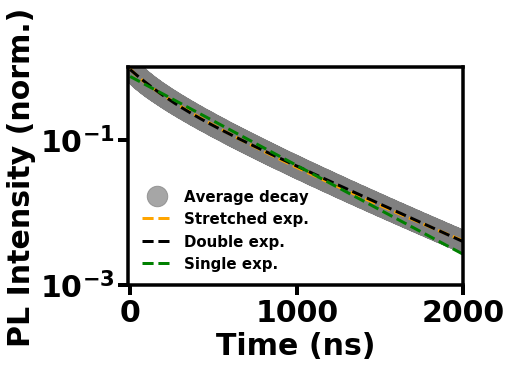

In [187]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_HLI_avg/np.max(pl_HLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.legend(fontsize=15, frameon=False)
plt.xlim(-10, 2000)
plt.ylim(0.001, 1)




### Calculation of theoretical tau  
$I = I_0e^{(\frac{-t}{\tau})}$ when t = $\tau$ and $I = \frac{I_0}{e}$

In [44]:
PL_e_HLI = np.max(pl_HLI, axis=0)/np.e
PL_e_HLI.size

50

In [37]:
#function to calulate the index of the PL/e values in the "pl" database by looking at the nearest neighbor of the "PL_e_values" inside "pl"
def find_idx(array, value):
    return (np.abs(array - value)).argmin()

In [38]:
# index of PL data calculated considering each array inside the array of pl singularly
time_PL_HLI = np.array([])
for ix, i in enumerate(PL_e_HLI):
    b = find_idx(pl_HLI[:, ix], i)
    time_PL_HLI = np.append(time_PL_HLI, b)
time_PL_HLI

NameError: name 'PL_e_HLI' is not defined

In [47]:
# array of lifetime at which PL=PL0/e
lifetime_HLI = np.array([])
for i in time_PL_HLI:
    lifetime_HLI = np.append(lifetime_HLI, t[int(i)]) 
lifetime_HLI*1e9

array([500.10002   , 455.0910182 , 414.08281656, 377.07541508,
       343.06861372, 312.06241248, 284.05681136, 259.05181036,
       236.04720944, 215.0430086 , 195.0390078 , 178.03560712,
       162.03240648, 147.02940588, 134.02680536, 122.02440488,
       111.02220444, 101.02020404,  92.01840368,  84.01680336,
        76.01520304,  69.01380276,  63.01260252,  58.01160232,
        52.01040208,  48.00960192,  43.00860172,  40.0080016 ,
        36.00720144,  33.00660132,  30.0060012 ,  27.00540108,
        25.005001  ,  22.00440088,  20.0040008 ,  19.00380076,
        17.00340068,  15.0030006 ,  14.00280056,  13.00260052,
        12.00240048,  11.00220044,  10.0020004 ,   9.00180036,
         8.00160032,   7.00140028,   7.00140028,   6.00120024,
         6.00120024,   5.0010002 ])

In [39]:
avg_lifetime_HLI = np.average(lifetime_HLI, weights=pl_HLI_sum, axis=-1)
avg_lifetime_HLI*1e9

NameError: name 'lifetime_HLI' is not defined

(0, 400)

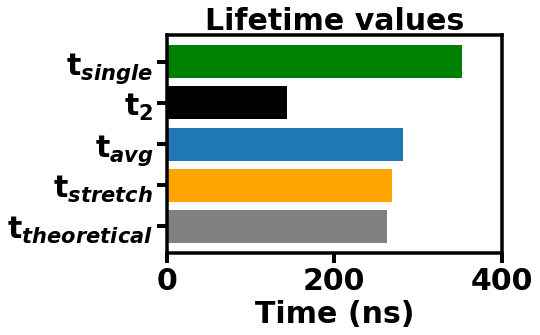

In [50]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_HLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
plt.barh("t$_{avg}$", double_exp[4]*1e9)
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("Time (ns)", fontsize =30 , fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0,400)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)

In [51]:
surf_lifetime_avg = calculate_surface_lifetime(avg_lifetime_HLI*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg mono exp. fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg mono exp. fitting = " +str(SRV_avg_mono[1]) +' cm/s' )

SRV1=0 theoretical value = 147.28003589558122 cm/s
SRV1=SRV2 theoretical value = 73.49378894766144 cm/s
SRV1=0 from stretched exp fitting = 144.2808286430651 cm/s
SRV1=SRV2 from stretched exp fitting = 72.00007461448082 cm/s
SRV1=0 from tau 2 of biexp fitting = 274.58280096833244 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 136.78400378940088 cm/s
SRV1=0 from tau avg biexp fitting = 136.9780772456085 cm/s
SRV1=SRV2 from tau avg biexp fitting = 68.36253347278078 cm/s
SRV1=0 from tau avg mono exp. fitting = 108.57162807229321 cm/s
SRV1=SRV2 from tau avg mono exp. fitting = 54.20630707353575 cm/s


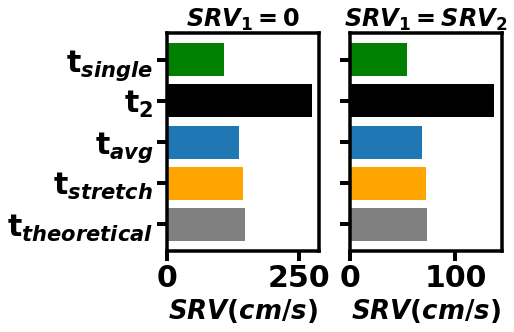

In [77]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$", fontsize= 24)
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26,fontweight='bold')
ax1.tick_params(direction='out', length=10, width=4)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$", fontsize= 24)
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

ax2.tick_params(direction='out', length=10, width=4)


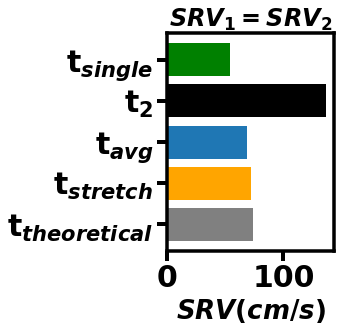

In [75]:
plt.figure(figsize=(3,4))
plt.barh("t$_{theoretical}$", SRV_avg[1], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[1])
plt.barh("t$_{2}$", SRV_avg_tau2[1], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[1], color='green')
plt.title("$SRV_{1} = SRV_{2}$", fontsize= 24)
plt.xlabel("$SRV (cm/s)$", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

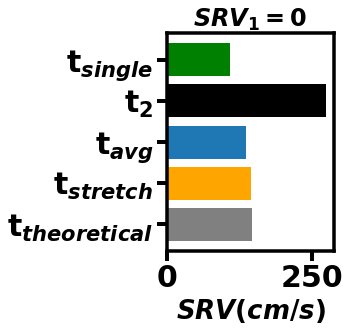

In [76]:
plt.figure(figsize=(3,4))
plt.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[0])
plt.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[0], color='green')
plt.title("$SRV_{1} = 0$", fontsize= 24)
plt.xlabel("$SRV (cm/s)$", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

## 2) Simulation of PL decays in LLI with a *linear distribution* of K_nonrad from 10^6 to 10^8 cm-3 

In [78]:
#creation of LLI PL decay curves and average decay curve

# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_LLI = photoluminescence_LLI(t = np.linspace(0,5000, 5000)*1e-9, k1= np.logspace(6, 8, 50))
pl_LLI

#weighted sum of photoluminescence data
pl_LLI_sum = pl_LLI.sum(axis=0)
pl_LLI_sum

#weighted average og the photoluminescence data
pl_LLI_avg = np.average(pl_LLI, weights=pl_LLI_sum, axis=-1)
pl_LLI_avg

array([1.65868339e+14, 1.65118392e+14, 1.64384595e+14, ...,
       2.13902265e+11, 2.13664968e+11, 2.13427940e+11])

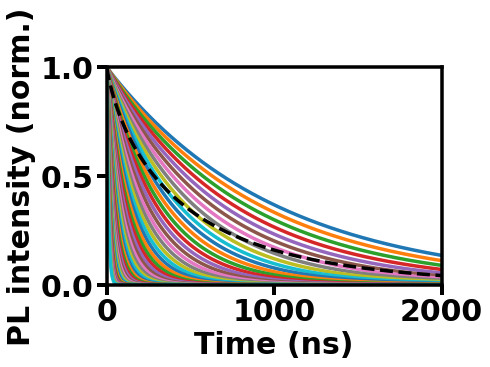

In [84]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_LLI/np.max(pl_LLI))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0, 2000)
plt.ylim(0,1)
plt.show()

In [86]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 467.5436625524226
Beta = 0.7920821897033296
avg. tau (ns) = 533.5549020383708


In [88]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 267.37114721124186
a1 = 0.43896531904084957
tau2 (ns) = 816.4485341124577
a2 = 0.5013807006990363
avg. tau (ns) = 560.1323215060816


In [89]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [90]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 694.4109328081117
a = 0.763677734466686
avg. tau (ns) = 694.4109328081117


(0.05, 1)

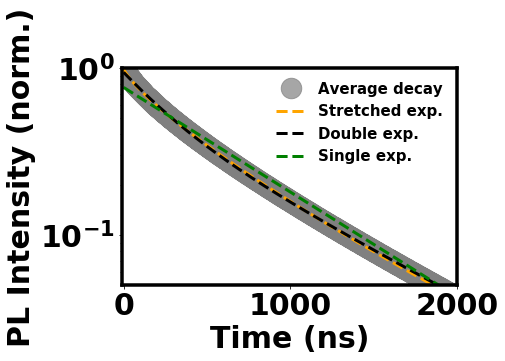

In [92]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15, frameon=False)
plt.xlim(-10, 2000)
plt.ylim(0.05, 1)

In [93]:
#Mathematical derivation of theoretical average lifetime from weighted average of each time at which I = I0/e

#photoluminescence maximum from LLI regime divided by e
PL_e_LLI = np.max(pl_LLI, axis=0)/np.e
PL_e_LLI.size

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_PL_LLI = np.array([])
for ix, i in enumerate(PL_e_LLI):
    b = find_idx(pl_LLI[:, ix], i)
    time_PL_LLI = np.append(time_PL_LLI, b)
time_PL_LLI

# array of lifetime at which PL=PL0/e at LLI
lifetime_LLI = np.array([])
for i in time_PL_LLI:
    lifetime_LLI = np.append(lifetime_LLI, t[int(i)]) 
lifetime_LLI*1e9

#weighted average of calculate lifetimes with pl_sum weights
avg_lifetime_LLI = np.average(lifetime_LLI, weights=pl_LLI_sum, axis=-1)
avg_lifetime_LLI*1e9

527.0643452430687

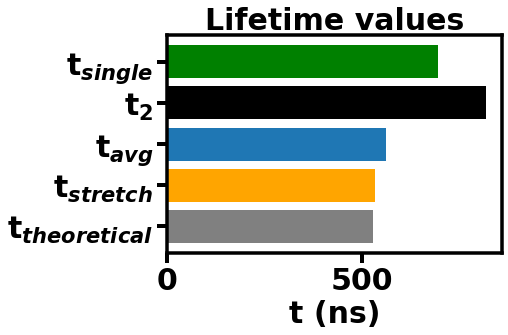

In [94]:

#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_LLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
plt.barh("t$_{avg}$", double_exp[4]*1e9)
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)
#plt.xlim(0, 1000)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)

SRV1=0 theoretical value = 70.98270372725958 cm/s
SRV1=SRV2 theoretical value = 35.457350384677824 cm/s
SRV1=0 from stretched exp fitting = 70.0571496052777 cm/s
SRV1=SRV2 from stretched exp fitting = 34.9954538298038 cm/s
SRV1=0 from tau 2 of biexp fitting = 44.027566375106915 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 22.000697392346602 cm/s
SRV1=0 from tau avg biexp fitting = 66.49123788162991 cm/s
SRV1=SRV2 from tau avg biexp fitting = 33.21578243941328 cm/s
SRV1=0 from tau avg biexp fitting = 52.652668954646444 cm/s
SRV1=SRV2 from tau avg biexp fitting = 26.307621582879555 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

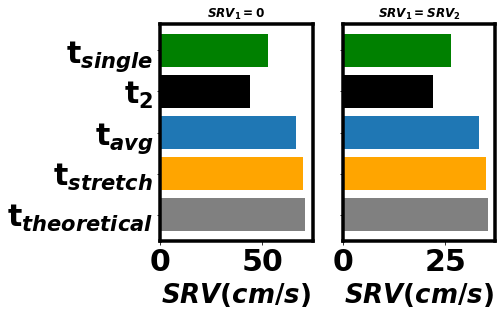

In [95]:


surf_lifetime_avg = calculate_surface_lifetime(avg_lifetime_LLI*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.barh("t$_{theoretical}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{theoretical}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

## Skew-Normal Distribution of k1 with a = 10


The Skew-Normal distribution is an extension of the normal (Gaussian) probability distribution, allowing for the presence of skewness.
The component $\alpha$ is what gives the distribution its "skewness" which regulates the shape of the density function. 

* when $\alpha=0$, the skewness vanishes, and we obtain the standard Normal density
* when $\alpha$ increases in absolute value , the skewness of the distribution increases.
* when  $\alpha\to\infty$ the density converges to the so-called half-normal (or folded normal) density function
* when the sign of $\alpha$ changes, the density is reflected on the opposite side of the vertical axis.

<a href="{http://azzalini.stat.unipd.it/SN/Intro/intro.html}">{Ref}</a>

For a random variable $x$ which has a standard skew normal distribution with skewness parameter $\alpha$, its probability density function is given by:


$f(x) = 2 \phi(x) \Phi(\alpha x)$

with :

$\phi(x)={\frac {1}{\sqrt {2\pi }}}\;e^{-x^{2}/2}$
$\qquad \Phi(\alpha x) = \int_{-\infty}^{\alpha x}\phi(t) dt$

Simple continuity equation considering just the radiative (k2) and defect-assisted non-radiative recombination (k1)
* k1 = skewed distribution with maximum at 1e6 ns and a size of 50 data points
* k2 = 2e-10 cm^3 s^-1
* n0 = 1e14
* t = 0 to 1000 ns

In [6]:
# skewed gaussian distribution of k1 values
#skew = skewnorm.rvs(a = 10, loc = 1e6, scale=9e6, size=50)

In [7]:
#skew 

In [8]:
skew = np.array([ 9490786.30513777,  7536630.11982634, 16454346.60930195,
       12547720.36848101,  3905472.07319704,  3529527.88225739,
        1266243.72953522,  6006013.55006531,  4602896.37435109,
        7964610.83358873, 13970152.25853891,  7357512.91416742,
        1182815.07376768, 11058965.25302741, 11441069.92801695,
        8752435.01119279,  4939621.14498479, 10144841.23073811,
        4309587.32480473,  8056163.80990646,  5918150.92607533,
        3003214.06507928, 11215807.32962731,  2407773.19636073,
         745245.40071062,  8106849.65451734,  4678521.29405187,
       18037650.95905221, 15634208.49448247,  3218300.79977616,
       11403450.57828473,  1680981.61896775,  3299021.97267475,
       14074921.58581428, 10855144.85579374,  8830888.35232471,
        9600350.04248585,  6832395.47780042,  7606054.25627072,
       21891340.96296946,  4774627.49634307,  9914665.74785788,
        1179542.21358483, 14082925.73768848,  2586264.61483294,
        7239004.41180339, 14384901.50760069,  6845284.87325528,
        5608360.70212701,  4814080.61690508])

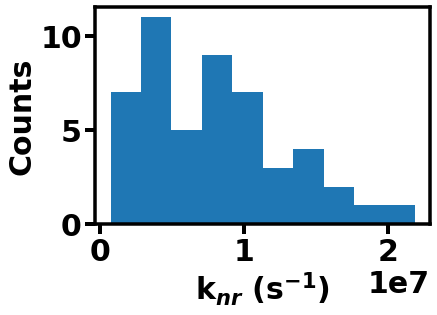

In [9]:
plt.figure()
plt.tick_params(length=8)
plt.hist(skew)
plt.xlabel("k$_{nr}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)

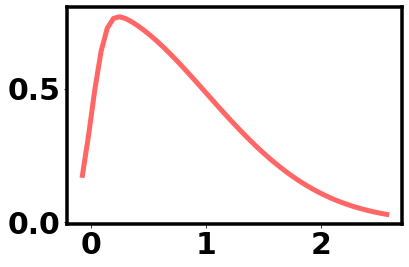

In [10]:
x = np.linspace(skewnorm.ppf(0.01, 10), skewnorm.ppf(0.99, 10), 50)
plt.plot(x, skewnorm.pdf(x, 10), 'r-', lw=5, alpha=0.6, label='skewnorm pdf')

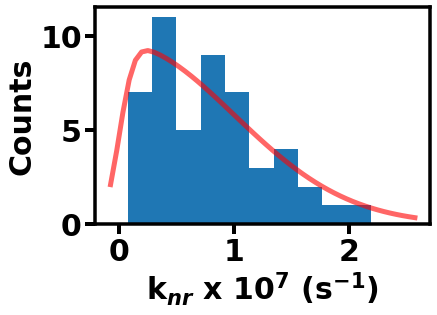

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, skewnorm.pdf(x, 10)*12, 'r-', lw=5, alpha=0.6, label='skewnorm pdf')
ax.hist(skew*1e-7)
plt.xlabel("k$_{nr}$ x 10$^{7}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)

In [64]:
#with knr closer to 1E7 s-1
skew_2 = skewnorm.rvs(a = 10, loc = 1e7, scale=9e7, size=50)

Text(0, 0.5, 'Counts')

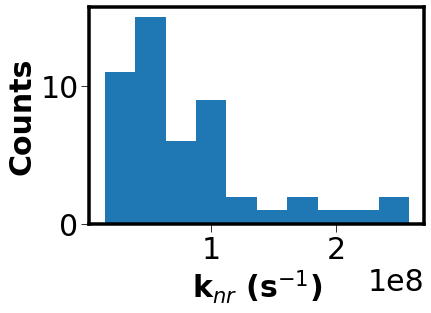

In [65]:
plt.figure()
plt.tick_params(length=8)
plt.hist(skew_2)
plt.xlabel("k$_{nr}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

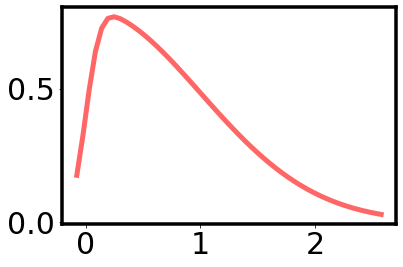

In [66]:
x = np.linspace(skewnorm.ppf(0.01, 10), skewnorm.ppf(0.99, 10), 50)
plt.plot(x, skewnorm.pdf(x, 10), 'r-', lw=5, alpha=0.6, label='skewnorm pdf')

Text(0, 0.5, 'Counts')

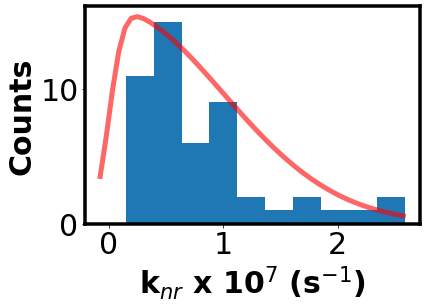

In [71]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, skewnorm.pdf(x, 10)*20, 'r-', lw=5, alpha=0.6, label='skewnorm pdf')
ax.hist(skew_2*1e-8)
plt.xlabel("k$_{nr}$ x 10$^{7}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

## 1) Simulation of PL decays in HLI with a *skewed distribution* of K_nonrad from 10^6 to 10^7 cm-3 

In [158]:
# PL decay curves for each k1 value 
pl_skew = photoluminescence_HLI(k1= skew, t=np.linspace(0,5000, 5000)*1e-9)
pl_skew

# weight of each decay curve
skew_sum = pl_skew.sum(axis=0)
skew_sum.size


# weighted average curve which is most likely the one we end up seeing as overall decay
pl_skew_avg = np.average(pl_skew, weights=skew_sum, axis=-1)
pl_skew_avg.size

5000

<function matplotlib.pyplot.show(*args, **kw)>

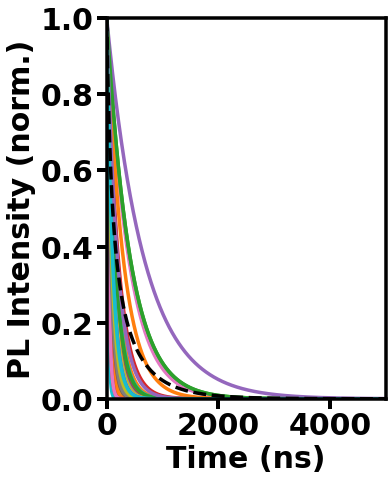

In [159]:
#plot of all exponetial decay for each k1 and average curve
plt.figure(figsize=(5,7))
plt.plot(t*1e9, pl_skew/np.max(pl_skew))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL Intensity (norm.)', fontsize =30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0, 5000)
plt.ylim(0,1)
plt.show

In [160]:
stretched_exp_skew = stretch_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau_c (ns) = "+str(stretched_exp_skew[0]*1e9))
print("Beta = "+str(stretched_exp_skew[1]))
print("avg. tau (ns) = "+str(stretched_exp_skew[3]*1e9))

tau_c (ns) = 173.91277546357477
Beta = 0.6507382705259843
avg. tau (ns) = 237.313614753899


In [161]:
double_exp_skew = double_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau1 (ns) = "+str(double_exp_skew[0]*1e9))
print("a1 = "+str(double_exp_skew[1]))
print("tau2 (ns) = "+str(double_exp_skew[2]*1e9))
print("a2 = "+str(double_exp_skew[3]))
print("avg. tau (ns) = "+str(double_exp_skew[4]*1e9))

tau1 (ns) = 126.25724544333264
a1 = 0.6116322829118271
tau2 (ns) = 546.7937219309484
a2 = 0.31209938396360687
avg. tau (ns) = 268.34306966322464


In [162]:
#triple_exp_skew = triple_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
#print("tau1 (ns) = "+str(triple_exp_skew[0]*1e9))
#print("a1 = "+str(triple_exp_skew[1]))
#print("tau2 (ns) = "+str(triple_exp_skew[2]*1e9))
#print("a2 = "+str(triple_exp_skew[3]))
#print("tau3 (ns) = "+str(triple_exp_skew[4]*1e9))
#print("a3 (ns) = "+str(triple_exp_skew[5]))
#print("avg. tau (ns) = "+str(triple_exp_skew[6]*1e9))

In [164]:
single_exp_skew = single_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau (ns) = "+str(single_exp_skew[0]*1e9))
print("a = "+str(single_exp_skew[1]))
print("avg. tau (ns) = "+str(single_exp_skew[2]*1e9))

tau (ns) = 431.9354370313315
a = 0.5936911545608788
avg. tau (ns) = 431.9354370313315


C:\Users\Margherita\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


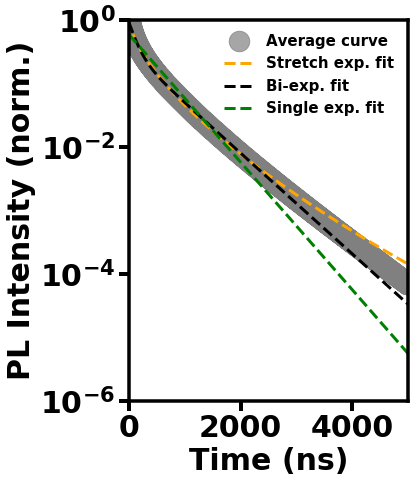

In [165]:
# plot average curve and multiple exponential fitting curves
#plt.figure(figsize=(10,8))
plt.figure(figsize=(5,7))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'C1o', color='grey', alpha=0.7,label="Average curve")
plt.plot(t*1e9, stretched_exp_skew[4], '--', color='orange', lw = 3, label="Stretch exp. fit")
plt.plot(t*1e9, double_exp_skew[5], 'k--', lw = 3, label="Bi-exp. fit")
#plt.plot(t*1e9, triple_exp_skew[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp_skew[3], 'g--', lw = 3, label="Single exp. fit")
plt.yscale('log')
plt.xlim(0, 5000)
plt.ylim(1E-6, 1)
plt.xlabel("Time (ns)", fontsize =30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize =30, fontweight ='bold')
plt.legend(fontsize=15, frameon=False)
plt.tick_params(direction='out', length=10, width=4)

In [166]:
#Mathematical deriation of lifetime from average curve knowing at $\tau$ : $I = \frac{I_0}{e}$

#photoluminescence maximum divided by e
PL_e_skew = np.max(pl_skew, axis=0)/np.e
PL_e_skew.size

# index of PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[ix, :], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[:, ix], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9


lifetime_skew_avg = np.average(lifetime_skew, weights= skew_sum, axis=-1)
lifetime_skew_avg*1e9

247.71463472950776

(0, 600)

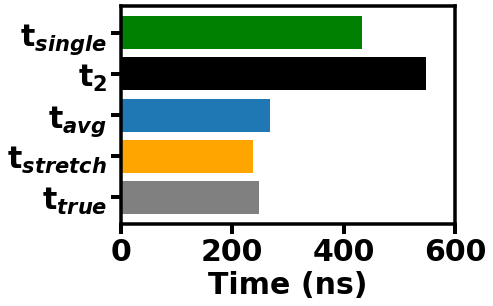

In [167]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
#plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{true}$", lifetime_skew_avg*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp_skew[3]*1e9, color = 'orange')
plt.barh("t$_{avg}$", double_exp_skew[4]*1e9)
plt.barh("t$_{2}$", double_exp_skew[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp_skew[2]*1e9, color= 'green')
plt.xlabel("Time (ns)", fontsize =30 , fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0, 600)
#plt.xlim(0,400, 20)

SRV1=0 theoretical value = 156.9184101984368 cm/s
SRV1=SRV2 theoretical value = 78.29323222559061 cm/s
SRV1=0 from stretched exp fitting = 164.03658656441996 cm/s
SRV1=SRV2 from stretched exp fitting = 81.83693846803328 cm/s
SRV1=0 from tau 2 of biexp fitting = 68.23749982672925 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 34.087326378596316 cm/s
SRV1=0 from tau avg biexp fitting = 144.43772378783547 cm/s
SRV1=SRV2 from tau avg biexp fitting = 72.07821709953073 cm/s
SRV1=0 from tau avg biexp fitting = 87.74489633654812 cm/s
SRV1=SRV2 from tau avg biexp fitting = 43.82050382941076 cm/s


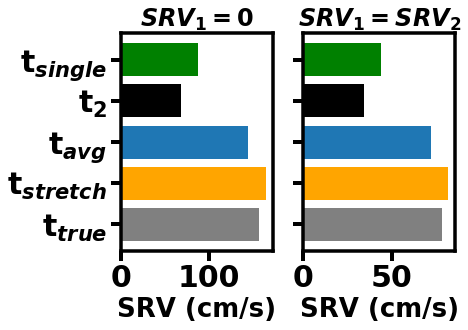

In [168]:
surf_lifetime_avg = calculate_surface_lifetime(lifetime_skew_avg*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp_skew[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp_skew[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp_skew[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp_skew[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


ax1.barh("t$_{true}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$", fontsize= 24)
ax1.set_xlabel("SRV (cm/s)", fontsize= 26)
ax1.tick_params(direction='out', length=10, width=4)

ax2.barh("t$_{true}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$", fontsize= 24)
ax2.set_xlabel("SRV (cm/s)", fontsize=26)
ax2.tick_params(direction='out', length=10, width=4)


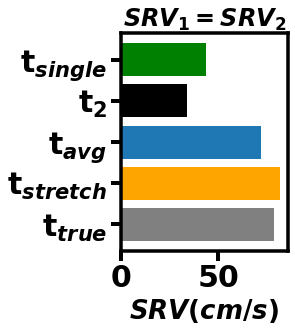

In [142]:
plt.figure(figsize=(3,4))
plt.barh("t$_{true}$", SRV_avg[1], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[1])
plt.barh("t$_{2}$", SRV_avg_tau2[1], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[1], color='green')
plt.title("$SRV_{1} = SRV_{2}$", fontsize= 24)
plt.xlabel("$SRV (cm/s)$", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

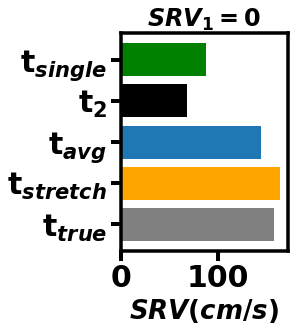

In [143]:
plt.figure(figsize=(3,4))
plt.barh("t$_{true}$", SRV_avg[0], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[0])
plt.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[0], color='green')
plt.title("$SRV_{1} = 0$", fontsize= 24)
plt.xlabel("$SRV (cm/s)$", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

## 4) Simulation of PL decays in HLI with a *skewed distribution* of K_nonrad from 10^6 to 10^7 cm-3 

In [144]:
# PL decay curves for each k1 value 
pl_skew = photoluminescence_LLI(k1= skew, t=np.linspace(0,5000, 5000)*1e-9)
pl_skew

# weight of each decay curve
skew_sum = pl_skew.sum(axis=0)
skew_sum.size


# weighted average curve which is most likely the one we end up seeing as overall decay
pl_skew_avg = np.average(pl_skew, weights=skew_sum, axis=-1)
pl_skew_avg.size

5000

(0, 1)

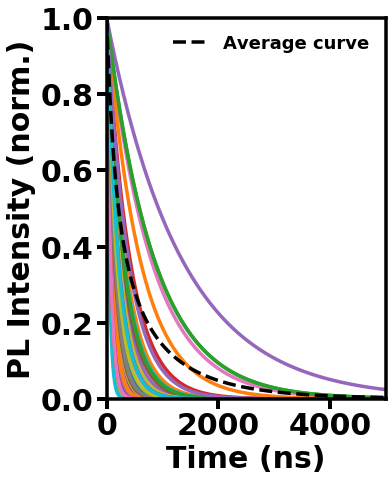

In [145]:
#plot of all exponetial decay for each k1 and average curve
plt.figure(figsize=(5,7))
plt.plot(t*1e9, pl_skew/np.max(pl_skew))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'k--', label="Average curve")
plt.xlabel('Time (ns)', fontsize= 30, fontweight ='bold' )
plt.ylabel('PL Intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.legend(fontsize=18, frameon=False)
plt.xlim(0,5000)
plt.ylim(0,1)

In [147]:
stretched_exp_skew = stretch_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau_c (ns) = "+str(stretched_exp_skew[0]*1e9))
print("Beta = "+str(stretched_exp_skew[1]))
print("avg. tau (ns) = "+str(stretched_exp_skew[3]*1e9))

tau_c (ns) = 323.78722831287195
Beta = 0.6306246562053766
avg. tau (ns) = 457.98124525203747


In [148]:
double_exp_skew = double_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau1 (ns) = "+str(double_exp_skew[0]*1e9))
print("a1 = "+str(double_exp_skew[1]))
print("tau2 (ns) = "+str(double_exp_skew[2]*1e9))
print("a2 = "+str(double_exp_skew[3]))
print("avg. tau (ns) = "+str(double_exp_skew[4]*1e9))

tau1 (ns) = 225.07992879696891
a1 = 0.5934058494313066
tau2 (ns) = 1030.4912829215787
a2 = 0.3480427334743375
avg. tau (ns) = 522.8312604688882


In [149]:
single_exp_skew = single_exp_fit(pl_skew_avg/np.max(pl_skew_avg), t)
print("tau (ns) = "+str(single_exp_skew[0]*1e9))
print("a = "+str(single_exp_skew[1]))
print("avg. tau (ns) = "+str(single_exp_skew[2]*1e9))

tau (ns) = 799.7142950799116
a = 0.6307170269212343
avg. tau (ns) = 799.7142950799115


(0.001, 1)

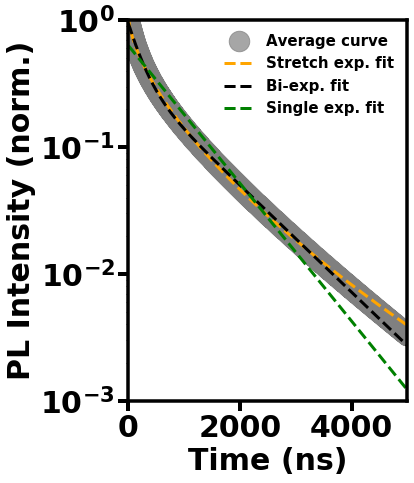

In [150]:
# plot average curve and multiple exponential fitting curves
plt.figure(figsize=(5,7))
plt.plot(t*1e9, pl_skew_avg/np.max(pl_skew_avg),'C1o', color='grey', alpha=0.7,label="Average curve")
plt.plot(t*1e9, stretched_exp_skew[4], '--', color='orange', lw = 3, label="Stretch exp. fit")
plt.plot(t*1e9, double_exp_skew[5], 'k--', lw = 3, label="Bi-exp. fit")
#plt.plot(t*1e9, triple_exp_skew[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp_skew[3], 'g--', lw = 3, label="Single exp. fit")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize= 30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize= 30, fontweight ='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.legend(fontsize=15, frameon=False)
plt.xlim(0, 5000)
plt.ylim(0.001, 1)

In [151]:
#Mathematical deriation of lifetime from average curve knowing at $\tau$ : $I = \frac{I_0}{e}$

#photoluminescence maximum divided by e
PL_e_skew = np.max(pl_skew, axis=0)/np.e
PL_e_skew.size

# index of PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[ix, :], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_skew_PL_e = np.array([])
for ix, i in enumerate(PL_e_skew):
    b = find_idx(pl_skew[:, ix], i)
    time_skew_PL_e = np.append(time_skew_PL_e, b)
time_skew_PL_e

# array of lifetime at which PL=PL0/e
lifetime_skew = np.array([])
for i in time_skew_PL_e:
    lifetime_skew = np.append(lifetime_skew, t[int(i)]) 
lifetime_skew*1e9


lifetime_skew_avg = np.average(lifetime_skew, weights= skew_sum, axis=-1)
lifetime_skew_avg*1e9

493.41055942608466

(0, 1100)

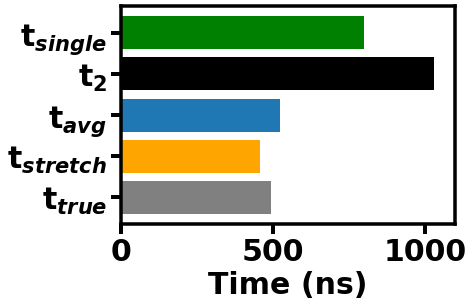

In [152]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
#plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{true}$", lifetime_skew_avg*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp_skew[3]*1e9, color = 'orange')
plt.barh("t$_{avg}$", double_exp_skew[4]*1e9)
plt.barh("t$_{2}$", double_exp_skew[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp_skew[2]*1e9, color= 'green')
plt.xlabel("Time (ns)", fontsize =30 , fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)
plt.xlim(0, 1100)

SRV1=0 theoretical value = 76.1727621220201 cm/s
SRV1=SRV2 theoretical value = 38.04722836069174 cm/s
SRV1=0 from stretched exp fitting = 82.46212546529527 cm/s
SRV1=SRV2 from stretched exp fitting = 41.18518156090501 cm/s
SRV1=0 from tau 2 of biexp fitting = 33.837047987882464 cm/s
SRV1=SRV2 from tau 2 of biexp fitting = 16.91079370992954 cm/s
SRV1=0 from tau avg biexp fitting = 71.59874022447498 cm/s
SRV1=SRV2 from tau avg biexp fitting = 35.76477618371243 cm/s
SRV1=0 from tau avg biexp fitting = 45.05439715235294 cm/s
SRV1=SRV2 from tau avg biexp fitting = 22.513495467455225 cm/s


Text(0.5, 0, '$SRV (cm/s)$')

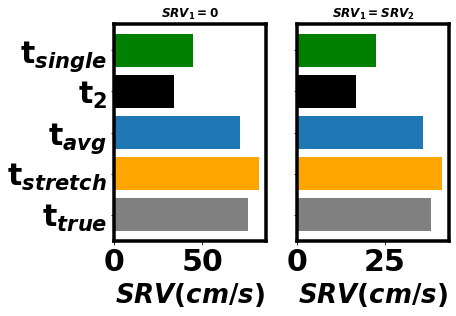

In [154]:
surf_lifetime_avg = calculate_surface_lifetime(lifetime_skew_avg*1e9)
SRV_avg = calculate_srv (surf_lifetime_avg)
print("SRV1=0 theoretical value = " +str(SRV_avg[0]) +' cm/s')
print("SRV1=SRV2 theoretical value = " +str(SRV_avg[1]) +' cm/s' )

surf_lifetime_stretch = calculate_surface_lifetime(stretched_exp_skew[3]*1e9)
SRV_avg_stretch = calculate_srv (surf_lifetime_stretch)
print("SRV1=0 from stretched exp fitting = " +str(SRV_avg_stretch[0]) +' cm/s')
print("SRV1=SRV2 from stretched exp fitting = " +str(SRV_avg_stretch[1]) +' cm/s' )

surf_lifetime_tau_2 = calculate_surface_lifetime(double_exp_skew[2]*1e9)
SRV_avg_tau2 = calculate_srv (surf_lifetime_tau_2)
print("SRV1=0 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[0]) +' cm/s')
print("SRV1=SRV2 from tau 2 of biexp fitting = " +str(SRV_avg_tau2[1]) +' cm/s' )

surf_lifetime_bi = calculate_surface_lifetime(double_exp_skew[4]*1e9)
SRV_avg_bi = calculate_srv (surf_lifetime_bi)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_bi[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_bi[1]) +' cm/s' )

surf_lifetime_mono = calculate_surface_lifetime(single_exp_skew[2]*1e9)
SRV_avg_mono = calculate_srv (surf_lifetime_mono)
print("SRV1=0 from tau avg biexp fitting = " +str(SRV_avg_mono[0]) +' cm/s')
print("SRV1=SRV2 from tau avg biexp fitting = " +str(SRV_avg_mono[1]) +' cm/s' )


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


ax1.barh("t$_{true}$", SRV_avg[0], color='grey')
ax1.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
ax1.barh("t$_{avg}$", SRV_avg_bi[0])
ax1.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
ax1.barh("t$_{single}$", SRV_avg_mono[0], color='green')
ax1.set_title("$SRV_{1} = 0$")
ax1.set_xlabel("$SRV (cm/s)$", fontsize= 26)

ax2.barh("t$_{true}$",SRV_avg[1], color='grey')
ax2.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
ax2.barh("t$_{avg}$", SRV_avg_bi[1])
ax2.barh("t$_{2}$",SRV_avg_tau2[1], color='black')
ax2.barh("t$_{single}$", SRV_avg_mono[1], color='green')
ax2.set_title("$SRV_{1} = SRV_{2}$")
ax2.set_xlabel("$SRV (cm/s)$", fontsize=26)

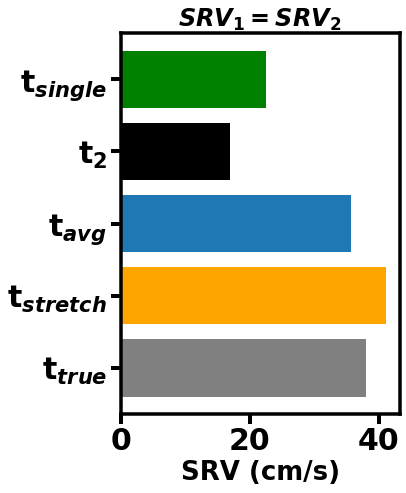

In [157]:
plt.figure(figsize=(5,7))
plt.barh("t$_{true}$", SRV_avg[1], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[1], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[1])
plt.barh("t$_{2}$", SRV_avg_tau2[1], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[1], color='green')
plt.title("$SRV_{1} = SRV_{2}$", fontsize= 24)
plt.xlabel("SRV (cm/s)", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

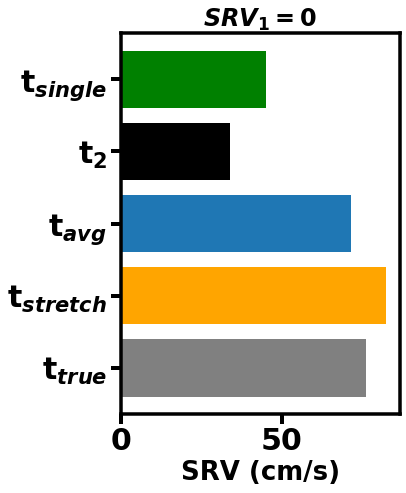

In [156]:
plt.figure(figsize=(5,7))
plt.barh("t$_{true}$", SRV_avg[0], color='grey')
plt.barh("t$_{stretch}$", SRV_avg_stretch[0], color='orange')
plt.barh("t$_{avg}$", SRV_avg_bi[0])
plt.barh("t$_{2}$", SRV_avg_tau2[0], color='black')
plt.barh("t$_{single}$", SRV_avg_mono[0], color='green')
plt.title("$SRV_{1} = 0$", fontsize= 24)
plt.xlabel("SRV (cm/s)", fontsize= 26,fontweight='bold')
plt.tick_params(direction='out', length=10, width=4)

## Gaussian distribution

In [255]:
 #g = np.random.normal(loc = 1e6, scale=1e5, size=50)

In [256]:
#g = np.absolute(gauss)

In [257]:
g = np.array([1031993.91473643, 1132375.34981278, 1035476.90224385,
       1152538.17653732,  917630.63142193, 1094370.89066439,
        961679.82066201, 1026167.14406566, 1063405.68478251,
       1080583.83750388, 1054543.19893835, 1126847.23950423,
        806766.31116755,  886997.29457306,  976979.40971966,
       1170040.773312  , 1004174.29235944,  958090.91535423,
       1045881.52284415,  884765.21388357, 1128716.33123089,
       1010249.50958783, 1102184.99214782, 1078083.40352149,
       1085872.81411233,  866339.55625633, 1174729.18159485,
       1083267.42426884, 1081508.21779547, 1096184.67784493,
       1061660.39664209,  965880.79754495,  949061.89626413,
       1035848.23940079,  875379.6533322 , 1075837.72417463,
       1039464.85935287, 1275808.04305661,  928450.44554653,
        966076.75085522,  947512.07256429, 1125204.80268722,
        871208.69875131, 1203221.20237626,  907305.89631062,
       1015794.42877552,  931860.78600798,  976054.85161622,
       1015790.00915211, 1004858.93430495])

Text(0, 0.5, 'Counts')

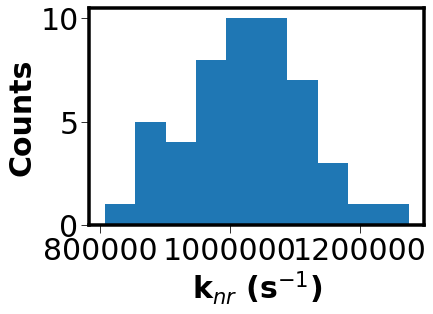

In [258]:
plt.figure()
plt.tick_params(length=8)
plt.hist(g)
plt.xlabel("k$_{nr}$ (s$^{-1}$)", fontsize =30, fontweight ='bold')
#plt.xscale("log")
plt.ylabel('Counts', fontsize =30, fontweight ='bold')

(800000.0, 1300000.0)

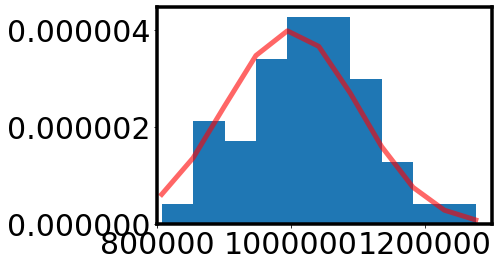

In [259]:
fig, ax = plt.subplots(1, 1)
bins=10
mu = 1e6
sigma = 1e5
count, bins, ignored = ax.hist(g, 10, density=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),'r-', lw=5, alpha=0.6)
plt.xlim(0.8e6, 1.3e6)

## 1) Simulation of PL decays in LLI with a *gaussian distribution* of K_nonrad around 10^6 cm-3 

In [260]:
#creation of LLI PL decay curves and average decay curve

# photoluminescence database from k1 from 1e5 to 1e7 and time from 0 to 1000ns
pl_LLI = photoluminescence_LLI(k1=g, t = np.linspace(0,5000, 5000)*1e-9)
pl_LLI

#weighted sum of photoluminescence data
pl_LLI_sum = pl_LLI.sum(axis=0)
pl_LLI_sum

#weighted average og the photoluminescence data
pl_LLI_avg = np.average(pl_LLI, weights=pl_LLI_sum, axis=-1)
pl_LLI_avg

array([5.52894464e+13, 5.52332420e+13, 5.51770952e+13, ...,
       3.85056995e+11, 3.84683088e+11, 3.84309546e+11])

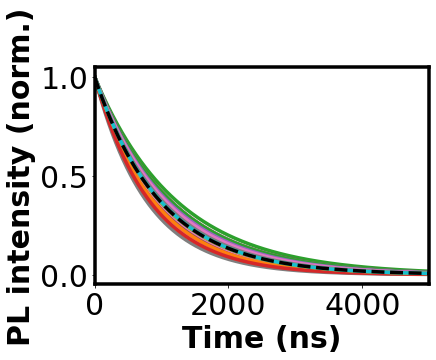

In [261]:
#plot of exponential decay of photoluminescence
plt.plot(t*1e9, pl_LLI/np.max(pl_LLI))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'k--', label="Average")
plt.xlabel('Time (ns)', fontsize =30, fontweight ='bold')
plt.ylabel('PL intensity (norm.)', fontsize= 30, fontweight ='bold')
plt.xlim(0, 5000)
plt.show()

In [263]:
#streched exponential fitting of the average PL exponential decay
stretched_exp = stretch_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau_c (ns) = "+str(stretched_exp[0]*1e9))
print("Beta = "+str(stretched_exp[1]))
print("avg. tau (ns) = "+str(stretched_exp[3]*1e9))

tau_c (ns) = 983.2400820093366
Beta = 0.9881394369461025
avg. tau (ns) = 988.2881594747388


In [265]:
#double exponential fitting of the average PL exponential decay
double_exp = double_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau1 (ns) = "+str(double_exp[0]*1e9))
print("a1 = "+str(double_exp[1]))
print("tau2 (ns) = "+str(double_exp[2]*1e9))
print("a2 = "+str(double_exp[3]))
print("avg. tau (ns) = "+str(double_exp[4]*1e9))

tau1 (ns) = 907.9935037816405
a1 = 0.5619425568684233
tau2 (ns) = 1100.9672940087773
a2 = 0.4380416220972959
avg. tau (ns) = 992.5253932569199


In [266]:
#triple exponential fitting of the average PL exponential decay
#triple_exp = triple_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
#print("tau1 (ns) = "+str(triple_exp[0]*1e9))
#print("a1 = "+str(triple_exp[1]))
#print("tau2 (ns) = "+str(triple_exp[2]*1e9))
#print("a2 = "+str(triple_exp[3]))
#print("tau3 (ns) = "+str(triple_exp[4]*1e9))
#print("a3 (ns) = "+str(triple_exp[5]))
#print("avg. tau (ns) = "+str(triple_exp[6]*1e9))

In [267]:
#single exponential fitting of the average PL exponential decay
single_exp = single_exp_fit(pl_LLI_avg/np.max(pl_LLI_avg), t)
print("tau (ns) = "+str(single_exp[0]*1e9))
print("a = "+str(single_exp[1]))
print("avg. tau (ns) = "+str(single_exp[2]*1e9))

tau (ns) = 998.5204010459461
a = 0.9934088570327163
avg. tau (ns) = 998.5204010459461


(0.1, 1)

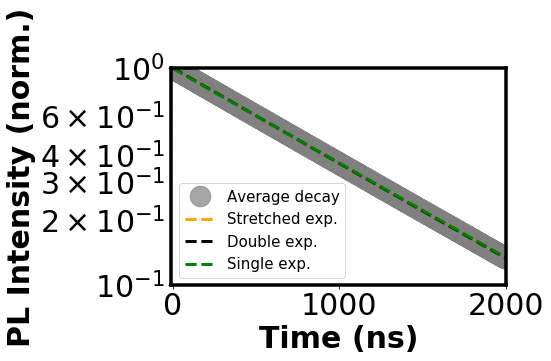

In [268]:
# plot fitting functions of the average PL exponential decay
#plt.figure(figsize=(10,8))
plt.plot(t*1e9, pl_LLI_avg/np.max(pl_LLI_avg),'C1o',color= 'grey', alpha=0.7,label="Average decay")
plt.plot(t*1e9, stretched_exp[4], '--',color='orange', lw = 3, label="Stretched exp.")
plt.plot(t*1e9, double_exp[5], 'k--', lw = 3, label="Double exp.")
#plt.plot(t*1e9, triple_exp[7], 'c--', lw = 3, label="triple exp fit")
plt.plot(t*1e9, single_exp[3], 'g--', lw = 3, label="Single exp.")
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("PL Intensity (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15)
plt.xlim(-10, 2000)
plt.ylim(0.1, 1)

In [269]:
#Mathematical derivation of theoretical average lifetime from weighted average of each time at which I = I0/e

#photoluminescence maximum from LLI regime divided by e
PL_e_LLI = np.max(pl_LLI, axis=0)/np.e
PL_e_LLI.size

# index of LLI PL data calculated considering each array inside the array of pl singularly
time_PL_LLI = np.array([])
for ix, i in enumerate(PL_e_LLI):
    b = find_idx(pl_LLI[:, ix], i)
    time_PL_LLI = np.append(time_PL_LLI, b)
time_PL_LLI

# array of lifetime at which PL=PL0/e at LLI
lifetime_LLI = np.array([])
for i in time_PL_LLI:
    lifetime_LLI = np.append(lifetime_LLI, t[int(i)]) 
lifetime_LLI*1e9

#weighted average of calculate lifetimes with pl_sum weights
avg_lifetime_LLI = np.average(lifetime_LLI, weights=pl_LLI_sum, axis=-1)
avg_lifetime_LLI*1e9

992.5289303138053

(0, 1500)

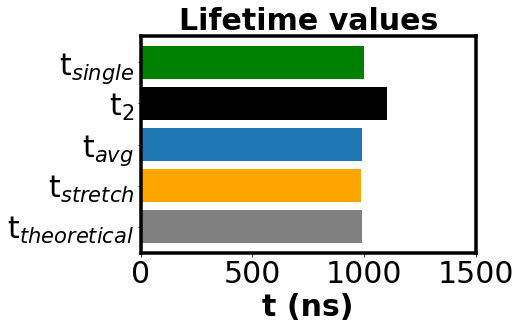

In [273]:
#plot of different tau values, from mathematical calculation (reference) and fitting functions
plt.figure()
plt.title("Lifetime values", fontsize=30, fontweight="bold")
plt.barh("t$_{theoretical}$", avg_lifetime_LLI*1e9, color='grey')
plt.barh("t$_{stretch}$", stretched_exp[3]*1e9, color = 'orange')
plt.barh("t$_{avg}$", double_exp[4]*1e9)
plt.barh("t$_{2}$", double_exp[2]*1e9, color='black')
plt.barh("t$_{single}$", single_exp[2]*1e9, color= 'green')
plt.xlabel("t (ns)", fontsize =30 , fontweight='bold')
plt.xlim(0, 1500)
#plt.barh("Triple Exp $\tau^{3}$", triple_exp[4]*1e9)
#plt.barh("Triple Exp $\tau^{avg}$", triple_exp[6]*1e9)

In [271]:
def fun(y, t, k1, k2=8e-11):
    #y1, y2 = y #y1 is the carrier concentration and y2 is the photon concentration in the film
    dy1dt = -k1*y - k2*y**2 #+ (c/n)*Alpha_avg*y2 #change in the carrier population as function of time
    #dy2dt = -(c/n)*Alpha_avg*y2 + (k_b*y1**2*P_stay) #change in the photon density as function of time
    return dy1dt

# Solve the coupled ODE's
def ode_solve(N0, k1, k2):#, k_A):
    return odeint(fun, N0 , t, args=(k1, k2))[:,0]
    



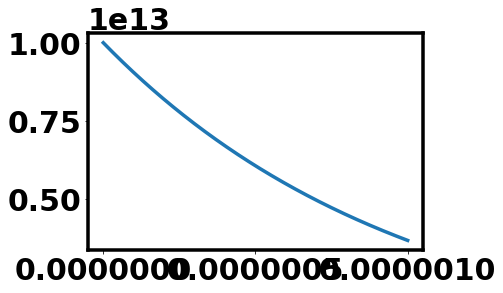

In [287]:
t = np.linspace(0,1000, 1000)*1e-9
n = ode_solve(1e13, 1e6, 1e-11)
plt.plot(t,n)

In [273]:
ode_fit(pl_HLI_avg, t)

C:\Users\Margherita\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


KeyboardInterrupt: 

In [274]:
from scipy.optimize import curve_fit

In [275]:
popt, pcov = curve_fit(ode_solve, t, np.array(pl_HLI_avg), p0=[4e6, 0.85474e-11])   #, p0=guess)

KeyboardInterrupt: 

In [ ]:
popt

In [ ]:
pcov

(-1e-07, 5.1e-06)

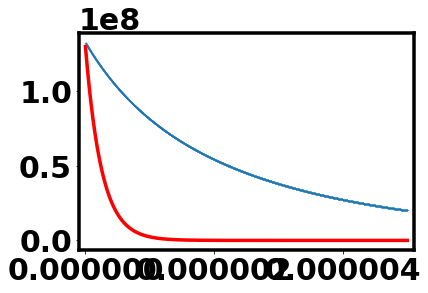

In [276]:
plt.scatter(t, pl_HLI_avg, s=.10)
#plt.plot(t, ode_solve(1e8, popt[0], popt[1]),color='red')
plt.plot(t, ode_solve(1.3e8, 4e6, 1e-6),color='red')
plt.xlim(-.00000010,0.0000051)

In [162]:
pl_HLI_avg[0]

132602095.99341922

In [203]:
def photoluminescence_HLI(t, k1):
    def model(n, t):
        k2 = 1e-12
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n0 = np.tile(np.power(10, 18), 50)
    n = odeint(model, n0, t)
    k2 = 1e-12
    pl_HLI = k2 * (n**2)
    return pl_HLI

In [206]:
pl = photoluminescence_HLI(t=np.linspace(0,5000, 5000)*1e-9, k1 = 1e6)

In [207]:
pl

array([[2.21003493e+06, 2.21003493e+06, 2.21003493e+06, ...,
        2.21003493e+06, 2.21003493e+06, 2.21003493e+06],
       [2.20561840e+06, 2.20561840e+06, 2.20561840e+06, ...,
        2.20561840e+06, 2.20561840e+06, 2.20561840e+06],
       [2.20121069e+06, 2.20121069e+06, 2.20121069e+06, ...,
        2.20121069e+06, 2.20121069e+06, 2.20121069e+06],
       ...,
       [1.00737658e+02, 1.00737658e+02, 1.00737658e+02, ...,
        1.00737658e+02, 1.00737658e+02, 1.00737658e+02],
       [1.00536344e+02, 1.00536344e+02, 1.00536344e+02, ...,
        1.00536344e+02, 1.00536344e+02, 1.00536344e+02],
       [1.00335432e+02, 1.00335432e+02, 1.00335432e+02, ...,
        1.00335432e+02, 1.00335432e+02, 1.00335432e+02]])

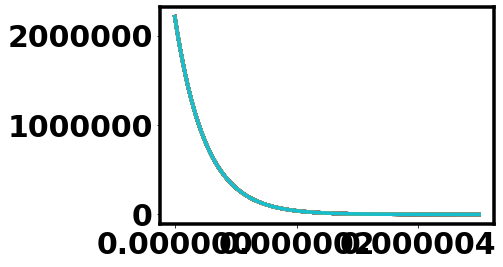

In [208]:
plt.plot(t,pl)

## LLI regime

In [816]:
LLI_exp = pd.read_csv(r"C:\Users\Margherita\OneDrive - UW\Documents\DATA\PL_lifetime_fit_work\HLI_LLI\LLI_0.5MHz_640nm_100pc_tail.csv", header=None)

In [817]:
LLI_time = LLI_exp[0].values
LLI_time

array([  15.872,   16.   ,   16.128, ..., 1969.28 , 1969.408, 1969.536])

In [818]:
LLI_counts = LLI_exp[1].values

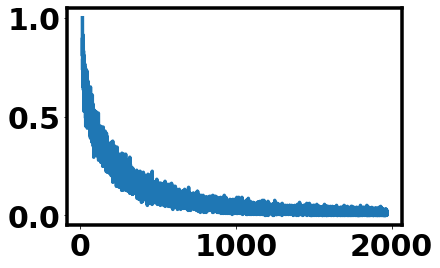

In [819]:
plt.plot(LLI_time, LLI_counts/np.max(LLI_counts))

In [820]:
# LLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def fit_LLI(t, k1, k2, p0, n0):
    def model(n, t):
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n = odeint(model, n0, t)
    pl_LLI = k2 * n* p0
    return pl_LLI

In [821]:
y_fit_LLI= fit_LLI(t=LLI_time*1e-9, k1=9e5, k2=2e-8, p0=1e13, n0=6.7e14)

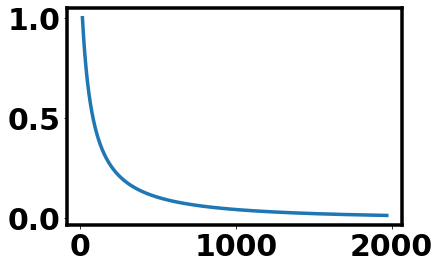

In [822]:
plt.plot(LLI_time, y_fit_LLI/np.max(y_fit_LLI))

(0.001, 1.5)

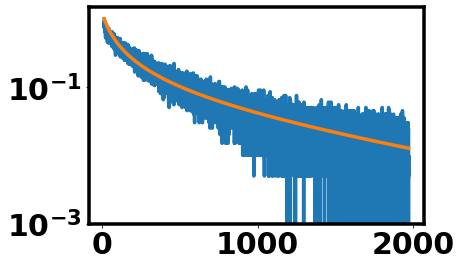

In [823]:
plt.plot(LLI_time, LLI_counts/np.max(LLI_counts))
plt.plot(LLI_time, y_fit_LLI/np.max(y_fit_LLI))
plt.yscale('log')
plt.ylim(1e-3, 1.5)

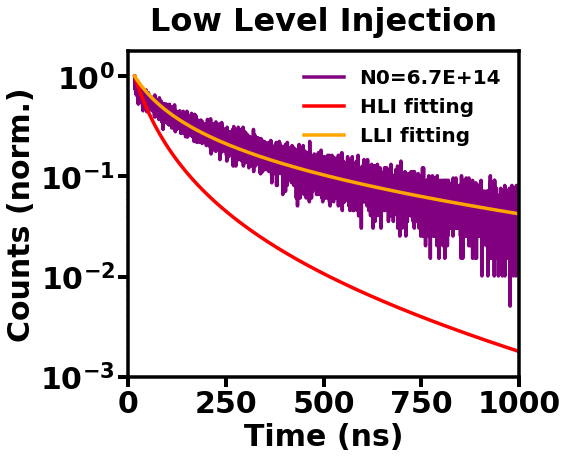

In [826]:
plt.figure(figsize=(7,6))
y_fit_HLI= fit_HLI(t=LLI_time*1e-9, k1=9e5, k2=2e-8, n0=6.7e14)
plt.plot(LLI_time, LLI_counts/np.max(LLI_counts), 'purple', label= 'N0=6.7E+14')
plt.plot(LLI_time, y_fit_HLI/np.max(y_fit_HLI), 'red', label= 'HLI fitting')
plt.plot(LLI_time, y_fit_LLI/np.max(y_fit_LLI), 'orange', label= 'LLI fitting')
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("Counts (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15, frameon=False)
plt.tick_params(direction='out', length=10, width=4)
plt.ylim(1e-3, 1.8)
plt.xlim([0, 1000])
plt.title('Low Level Injection',fontsize=32, fontweight ='bold', pad=20)
plt.legend(fontsize=20, frameon=False)

## HLI decay

In [806]:
HLI_exp = pd.read_csv(r"C:\Users\Margherita\OneDrive - UW\Documents\DATA\PL_lifetime_fit_work\HLI_LLI\HLI_corr.csv", header=None)

In [807]:
HLI_time = HLI_exp[0].values
HLI_counts = HLI_exp[1].values
HLI_time

array([0.00000000e+00, 6.39991800e-02, 1.27998350e-01, ...,
       3.50272011e+02, 3.50336006e+02, 3.50400002e+02])

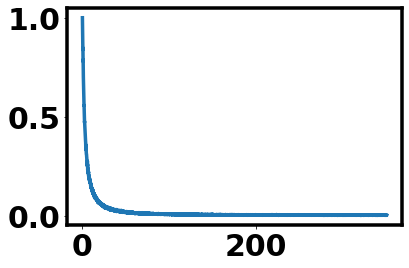

In [808]:
plt.plot(HLI_time, HLI_counts/np.max(HLI_counts))

In [809]:
# HLI continuity equation: dn/dt with k2, n0 as a constant and k1 as a variable
def fit_HLI(t, k1, k2, n0):
    def model(n, t):
        dndt = -(k2*(n**2) + k1*n)
        return dndt
    n = odeint(model, n0, t)
    pl_HLI = k2 * (n**2)
    return pl_HLI

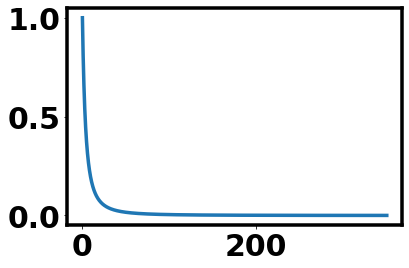

In [810]:
y_fit_HLI= fit_HLI(t=HLI_time*1e-9, k1=1e6, k2=9.5e-10, n0=1.4e17)
plt.plot(HLI_time, y_fit_HLI/np.max(y_fit_HLI))

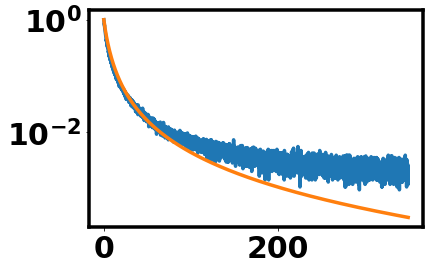

In [811]:
plt.plot(HLI_time, HLI_counts/np.max(HLI_counts))
plt.plot(HLI_time, y_fit_HLI/np.max(y_fit_HLI))
plt.yscale('log')

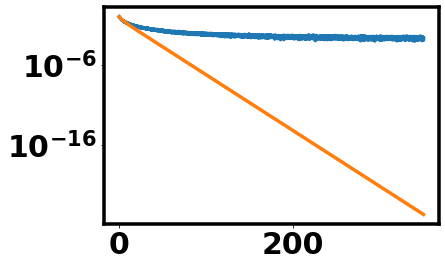

In [812]:
y_fit_LLI= fit_LLI(t=HLI_time*1e-9, k1=1.6e8, k2=9.5e-10, p0=1e13, n0=1.4e17)
plt.plot(HLI_time, HLI_counts/np.max(HLI_counts))
plt.plot(HLI_time, y_fit_LLI/np.max(y_fit_LLI))
plt.yscale('log')

(0, 350)

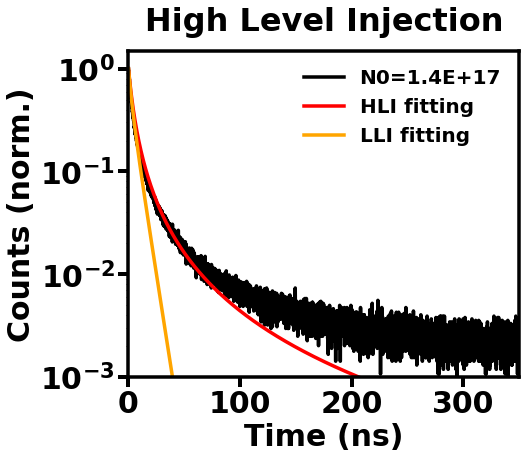

In [815]:
plt.figure(figsize=(7,6))
plt.plot(HLI_time, HLI_counts/np.max(HLI_counts), 'black', label='N0=1.4E+17')
plt.plot(HLI_time, y_fit_HLI/np.max(y_fit_HLI), 'red', label='HLI fitting')
plt.plot(HLI_time, y_fit_LLI/np.max(y_fit_LLI), 'orange', label='LLI fitting')
plt.yscale('log')
plt.xlabel("Time (ns)", fontsize=30, fontweight ='bold')
plt.ylabel("Counts (norm.)", fontsize=30, fontweight ='bold')
plt.legend(fontsize=15, frameon=False)
plt.tick_params(direction='out', length=10, width=4)
plt.ylim(1e-4, 1.5)
plt.xlim([0, 1000])
plt.title('High Level Injection',fontsize=32, fontweight ='bold', pad=20)
plt.legend(fontsize=20, frameon=False)
plt.ylim(1e-3, 1.5)
plt.xlim([0, 350])